# Multivariate Timeseries Forecasting of Dengue Cases  

# Initial Data Examination and Preliminary Cleaning - Univariate Focus

## Data Origins and General Description  

The data was obtained from Driven Data:  

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/  

It is comprised of timestamped environmental measurements suspected to have bearing on confirmed dengue cases in two cities:  San Juan, Puerto Rico and Iquitos, Peru.  The labels - number of dengue cases, also timestamped - are also provided for supervised learning approaches.  

The features are as listed:  

##### City and date indicators 
* city – City abbreviations: sj for San Juan and iq for Iquitos  
*  week_start_date – Date given in yyyy-mm-dd format  

##### NOAA's GHCN daily climate data weather station measurements  
* station_max_temp_c – Maximum temperature  
* station_min_temp_c – Minimum temperature  
* station_avg_temp_c – Average temperature  
* station_precip_mm – Total precipitation  
* station_diur_temp_rng_c – Diurnal temperature range  

For further reading:  https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

##### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)  
* precipitation_amt_mm – Total precipitation   

##### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)  
* reanalysis_sat_precip_amt_mm – Total precipitation  
* reanalysis_dew_point_temp_k – Mean dew point temperature  
* reanalysis_air_temp_k – Mean air temperature  
* reanalysis_relative_humidity_percent – Mean relative humidity  
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity  
* reanalysis_precip_amt_kg_per_m2 – Total precipitation  
* reanalysis_max_air_temp_k – Maximum air temperature  
* reanalysis_min_air_temp_k – Minimum air temperature  
* reanalysis_avg_temp_k – Average air temperature  
* reanalysis_tdtr_k – Diurnal temperature range  

For further reading:  https://www.nccs.nasa.gov/services/data-collections/coupled-products/cfsr#:~:text=The%20National%20Oceanic%20and%20Atmospheric,period%20(1979%2D2009).

##### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements  
* ndvi_se – Pixel southeast of city centroid  
* ndvi_sw – Pixel southwest of city centroid  
* ndvi_ne – Pixel northeast of city centroid  
* ndvi_nw – Pixel northwest of city centroid  

For an explanation of NDVI:  
Wikipedia:  "It has a high correlation with the true state of vegetation on the ground. The index is easy to interpret: NDVI will be a value between -1 and 1. An area with nothing growing in it will have an NDVI of zero. NDVI will increase in proportion to vegetation growth. An area with dense, healthy vegetation will have an NDVI of one. NDVI values less than 0 suggest a lack of dry land. An ocean will yield an NDVI of -1."  
https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index, accessed Feb 2 2024

## Data: Behavioural Characteristics Driving the Analysis

When the timestamped dengue cases are examined on their own, the process is a univariate timeseries forecasting exercise.  This only examines how previous dengue cases impact feature dengue cases to help identify if the output or dependent variable is autocorrelated.  To do this an autoregression (regressing against the same variable) is performed.

When the environmental measurements are included, it becomes a multivariate forecasting exercise.  In these scenarios, not only is autocorrelation of the dependent or predicted variable examined, but its correlation to the features, or time-lagged features, is also examined.  This is to establish whether a causal relationship between the features and predicted variable exists, and over what time lag.  There exists many model frameworks to enable this sort of analysis.

This notebook contains the steps to import the data, examine basic plots of the data and get a general description of its characteristics, then gather more details around the data's temporal characteristics with the use of lag-plots and autocorrelations.

## Import and Overview of Data Quality

The data are supplied as a set of training features, which is comprised of the environmental measurements, and training labels, which is simply the number of known dengue cases for each corresponding date.  The data is examined for its overall general characteristics like data type, mean, range, and for any anomalies as well as missing or duplicated data.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat


In [2]:
# setting up the file path structure
data_folder = os.path.join(os.pardir, 'data')
files_in_data = os.listdir(data_folder)
print(files_in_data)

['dengue_features_test.csv', 'dengue_features_train.csv', 'dengue_labels_train.csv']


The data provided by Driven Data for this practice competition does not include the test set's labels, which means model evaluations cannot be completed to satisfaction.  Performance on test data, including the test labels (actual target values) allows the model developer to determine if the models can produce acceptable predictions on unseen data.  

This will be addressed by treating the df_features and df_labels as though they were an entire un-split dataset, and they will later be split into a training and test set to allow for the model performance metrics to be calculated.  

The variables are named below as though they were not strictly training data.  

In [3]:
file_path1 = os.path.join(data_folder, 'dengue_features_train.csv')
df_features = pd.read_csv(file_path1)

file_path2 = os.path.join(data_folder, 'dengue_labels_train.csv')
df_labels = pd.read_csv(file_path2)

Let's get a sense of the size of the dataset.

In [4]:
print(df_features.shape)
print(df_labels.shape)

(1456, 24)
(1456, 4)


In [5]:
df_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [6]:
df_features.duplicated().sum()

0

In [7]:
df_features.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [8]:
df_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [9]:
df_labels.duplicated().sum()

0

In [10]:
df_labels.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

Merge the dataframes on city, year, and weekofyear.

In [11]:
pd.set_option('display.max_columns', None)
df = pd.merge(df_features, df_labels, on=['city', 'year', 'weekofyear'])
df.head(-5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,iq,2010,16,2010-04-23,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,299.507143,297.678571,304.7,294.7,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1,8
1447,iq,2010,17,2010-04-30,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,300.028571,296.468571,308.4,294.6,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4,4
1448,iq,2010,18,2010-05-07,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,298.585714,296.975714,304.7,294.6,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1,2
1449,iq,2010,19,2010-05-14,0.168686,0.158500,0.133071,0.145600,59.40,297.278571,297.935714,296.738571,306.0,294.0,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0,7


The two datasets, features and labels, are now merged on the common columns.  Every row of data, be it feature or label (target value) data now has a date column associated with it.  The row count is as expected (1451) and the columns total to 25, which reflects the total number of columns after the merge.  

A brief sanity check follows.

In [12]:
df.shape

(1456, 25)

In [13]:
df.duplicated().sum()

0

In [14]:
df.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

As seen earlier, there are no duplicates, but there are a number of nulls in the features.  This is investigated in the eda multivariate notebook.  The target, total_cases, does not have nulls.

Below are some quick statistics on each features, and below that, the statistics on the total cases we're aiming to predict.  
Range on the features can help indicate if some min-max scaling might be required.  The difference in magnitudes seen below indicate this will be required.

In [15]:
df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


Brief overview:
* We can see the dataset runs from 1990 to 2010
* Variable ranges vary from the very small (ndvi values) to larger (precipitation amounts)

`.info()` gives a quick idea of the datatypes, but also overall "type of information" gathered.  This dataset is entirely numerical except for the week_start_date column, which is likely string given the ojbect datatype.  Manipulations on week_start_date will require turning this into a datetime.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

We see most variables are floats, while the target is an integer, as are the year and weekofyear.  The week_start_date is object datatype, so it remains to be seen if it needs to be cast to datetime for the modelling algorithms that will later be used.  City is naturally object datatype.

Let's ensure that the time interval between rows is constant, eg. one week.  If not, rows either have to be dropped or data imputed (interpolated) to maintain a constant time interval.

In [17]:
df['weekstartdate_dt'] = pd.to_datetime(df['week_start_date'])

# Calculate the time difference between consecutive rows
df['time_interval'] = df['weekstartdate_dt'].diff()

# Check if the time interval is constant or changing
is_constant_interval = df['time_interval'].nunique() == 1

if is_constant_interval:
    constant_interval = df['time_interval'].iloc[0]
    print(f'Time interval is constant: {constant_interval}')
else:
    print('Time interval is changing.')
    unique_intervals = df['time_interval'].unique()
    print(f'Unique time intervals: {unique_intervals}')

    # Value counts for each unique time interval
    interval_counts = df['time_interval'].value_counts()
    print('Time interval value counts:')
    print(interval_counts)

# Optional: Print the DataFrame with the new 'time_interval' column
#df.head()


Time interval is changing.
Unique time intervals: <TimedeltaArray>
[NaT, '7 days', '8 days', '9 days', '-2852 days']
Length: 5, dtype: timedelta64[ns]
Time interval value counts:
time_interval
7 days        1426
8 days          21
9 days           7
-2852 days       1
Name: count, dtype: int64


Most intervals are 7 days, with only a few at 8 and 9 days.  For the purposes of modelling timeseries data, and given we're likely looking at time lags of weeks, not days, this variation in time interval will be considered to have negligible impact.

The interval of -2852 days is likely when the rows of data change from one city to the other.  Let's check.

In [18]:
df[df['time_interval']=='-2852 days']

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,weekstartdate_dt,time_interval
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.2472,25.41,296.74,298.45,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.4,10.775,32.5,20.7,3.0,0,2000-07-01,-2852 days


In [19]:
desired_value = '-2852 days'
row_indices = df.index[df['time_interval'] == desired_value]

print("Row Indices:", row_indices)

Row Indices: Index([936], dtype='int64')


In [20]:
# Get the preceding row
preceding_row_index = row_indices[0] - 1
preceding_row = df.iloc[preceding_row_index]
preceding_row

city                                                      sj
year                                                    2008
weekofyear                                                17
week_start_date                                   2008-04-22
ndvi_ne                                               -0.037
ndvi_nw                                            -0.010367
ndvi_se                                             0.077314
ndvi_sw                                             0.090586
precipitation_amt_mm                                     0.0
reanalysis_air_temp_k                             298.672857
reanalysis_avg_temp_k                             298.692857
reanalysis_dew_point_temp_k                           294.28
reanalysis_max_air_temp_k                              300.9
reanalysis_min_air_temp_k                              295.9
reanalysis_precip_amt_kg_per_m2                         2.17
reanalysis_relative_humidity_percent                   76.96
reanalysis_sat_precip_am

The city code changes from iq to sj when the large negative time interval occurs.  This confirms that the enormous negative interval is simply the switch of cities in the data.   

### Imputation 

We saw above there are no duplicates, but there are nulls.  Let's generare an overview of where the nulls are situated.

There are no nulls in the training labels, but there are varying amounts of nulls in the features.  For now those missing values will simply be imputed using the last value recorded, but there is room here for more sophisticated approaches.

> The risk with imputing using last value, particularly if there were any in the target variable "total_cases", is that if the spread of disease is on the rise, a "forward fill" imputation will under-report the case count.  It logically follows that if the spread of disease is receding, a "forward fill" imputation will over-report case counts.  Fortrunately there are no nulls in "total cases", so this particular risk is not in play, but this imputation's impact still needs to be considered for the features.

The heatmap below should help us see if nulls are concentrated in one city or in any given feature.

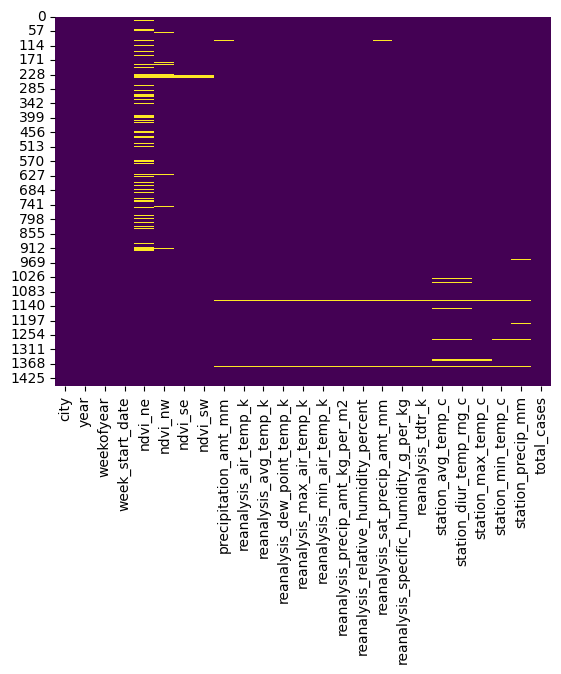

In [ ]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

There are a few rows where there's a large amount of nulls past the 1000 row mark.  Some features, like ndvi_ne seem to have a high number of nulls.  

The investigation below reveals San Juan is in the first 936 rows, while Iquitos is in rows 936 onward.  It would appear San Juan is more impacted by the nulls in feature ndvi_ne.  Iquitos is more impacted by the nearly all-null rows in the latter half of the dataset.

In [ ]:
df[df['city']=='sj']

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,sj,2008,13,2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
932,sj,2008,14,2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
933,sj,2008,15,2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
934,sj,2008,16,2008-04-15,0.001800,NaN,0.203900,0.209843,0.00,297.630000,297.778571,292.274286,299.7,295.9,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3


In [ ]:
(df[df['city']=='sj']).shape

(936, 25)

In [ ]:
df[df['city']=='iq']

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


In [ ]:
(df[df['city']=='iq']).shape

(520, 25)

As mentioned earlier, nulls for now will be very simply imputed using forward fill, which simply takes the last known value and enters it into the null locations for a given column.  This may be revisited for more sophisticated methods.

In [21]:
df.fillna(method='ffill', inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_11180\3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Pseudo-Redundant Features  

Before splitting the data by city and embarking on examining the timeseries plots on the features, some 'pseudo-redundant' features will be removed for conciseness.  We would otherwise end up with an enormous number of plots and later, a very large number of correlations to examine.  This is not an exhaustive analysis of the features that present the most useful information for feature selection - either on their own nor as measured against the target for preditive purposes - it is a simple measure taken to reduce the number of features that are very similar to each other.  This allows for a quick progression to confirm a basic model can be generated.  This crude "feature cull" can be revisited later.

In [22]:
temp_columns = df.filter(like='temp')
precip_columns = df.filter(like='precip')
print(temp_columns.columns)
print(precip_columns.columns)

Index(['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'],
      dtype='object')
Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_sat_precip_amt_mm', 'station_precip_mm'],
      dtype='object')


Note:  the "reanalysis" diurnal temperature range is missed in this check as one does not contain "temp" in its feature name.  This was caught and added to the work below.

May have to tease these apart a bit before plotting them to check for overlap.  Comparing an average temperature to a minimum isn't helfpul as they're not expected to be the same. The celsius temperatures would also have to be converted to Kelvin in order to compare properly.

Caution:  The station_diur_temp_rng_c should NOT go through any conversion as this is a temperature *difference*.

In [23]:
df['station_avg_temp_K_conv'] = df['station_avg_temp_c'] + 273.15
df['station_min_temp_K_conv'] = df['station_min_temp_c'] + 273.15
df['station_max_temp_K_conv'] = df['station_max_temp_c'] + 273.15

In [24]:
air_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_avg_temp_K_conv']
min_temp = ['reanalysis_min_air_temp_k', 'station_min_temp_K_conv']
max_temp = ['reanalysis_max_air_temp_k', 'station_max_temp_K_conv']
diurn_rg_temp = ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
precip_amt = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']

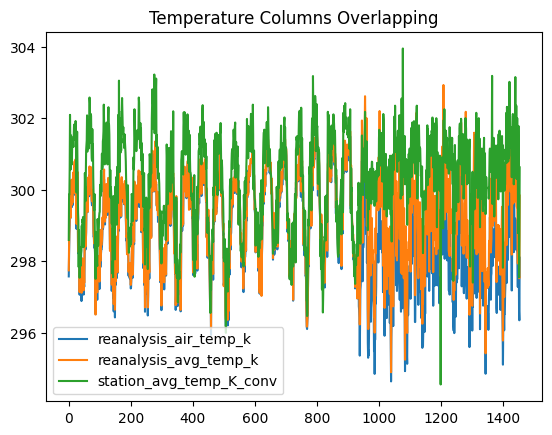

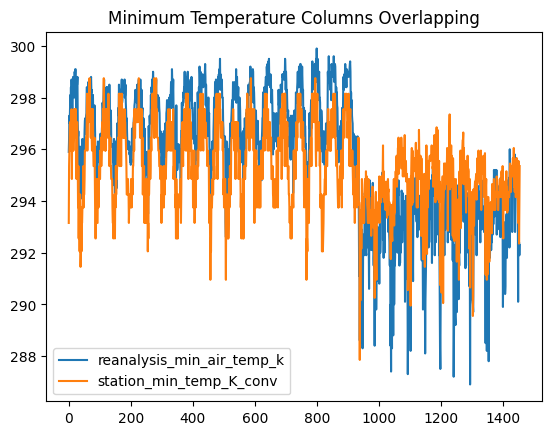

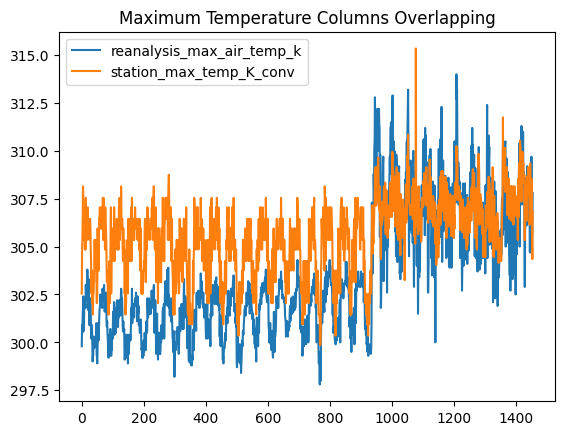

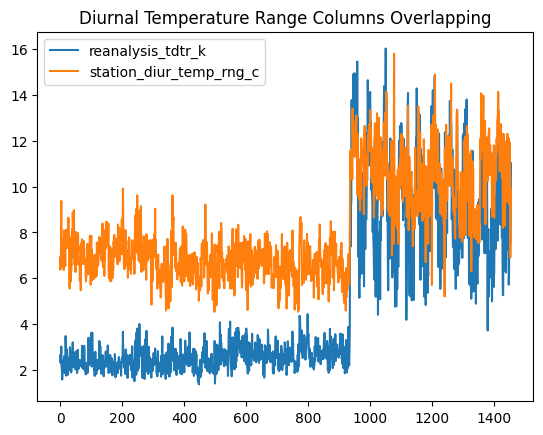

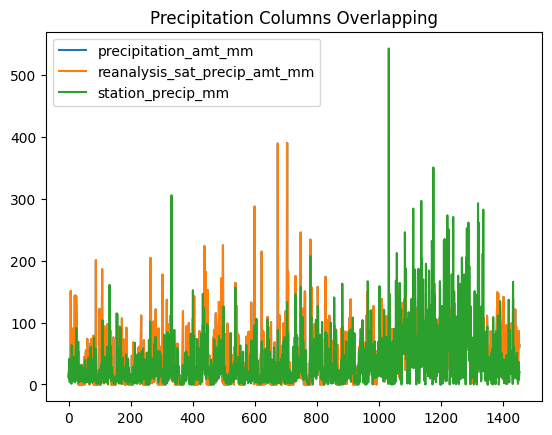

In [25]:
df[air_temp].plot(title='Temperature Columns Overlapping', legend=True)
plt.show()

df[min_temp].plot(title='Minimum Temperature Columns Overlapping', legend=True)
plt.show()

df[max_temp].plot(title='Maximum Temperature Columns Overlapping', legend=True)
plt.show()

df[diurn_rg_temp].plot(title='Diurnal Temperature Range Columns Overlapping', legend=True)
plt.show()

df[precip_amt].plot(title='Precipitation Columns Overlapping', legend=True)
plt.show()

There seems to be a noticeable difference between the 'reanalysis' temperature values and the 'station' temperature values.  There is currently no basis on which to choose one or the other, so the choice is entirely random at this point, until this work can be revisited for a better selection method.  The 'reanalysis' temperature values will be kept.  Similarly, the 'reanalysis' precipitation will be kept for consistency.

Additionally, the 'reanalysis' precipitation in kg/m2 will be kept as it is a different way to measure precipitation as compared to mm.  

A case could be made for dropping either reanalysis_air_temp_k or reanalysis_avg_temp_k as their statistics are very similar.  They'll be left in for now.  This could be explored further when an earnest feature selection effort is made for the multivariate EDA and modelling.  

The pseudo-redundant features will be dropped below, alongside the time interval variable created earlier for temporary investigative purposes.

In [26]:
redundant_features = (['station_avg_temp_c', 'station_avg_temp_K_conv', 'station_max_temp_c', 'station_max_temp_K_conv',
                       'station_min_temp_c', 'station_min_temp_K_conv', 'precipitation_amt_mm', 'station_precip_mm', 
                       'time_interval','station_diur_temp_rng_c'])

for r_feature in redundant_features:
    df.drop(r_feature, axis=1, inplace=True)

## Preparing the Data for Inputs to Models  

The below steps are taken to produce CSV files for each of San Juan and Iquitos for input to the modelling notebooks.

### Re-order Columns  
Here the column order will be decided to ensure weekstartdate_dt is first, and it will be set as index shortly.  The very next column (what will be the first column after the index is reset) will be total_cases as the models trialled in the modelling notebooks rely on the target being the first column.  

Note city, year, weekofyear, and week_start_date are all still included, but at the end.  We still need city to split this dataset by San Juan and Iquitos, and that's done shortly.  Then, these last four columns will be dropped as they will not provide useful input to the models.  The weekstartdate_dt column can always be used if the EDA and modelling efforts lead to more investigation around certain years.

In [27]:
column_order = (['weekstartdate_dt','total_cases','ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'city', 
       'year','weekofyear','week_start_date'])
df = df[column_order]

In [28]:
df.head()

,weekstartdate_dt,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,city,year,weekofyear,week_start_date
0,1990-04-30,4,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,sj,1990,18,1990-04-30
1,1990-05-07,5,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,sj,1990,19,1990-05-07
2,1990-05-14,4,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,sj,1990,20,1990-05-14
3,1990-05-21,3,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,sj,1990,21,1990-05-21
4,1990-05-28,6,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,sj,1990,22,1990-05-28


In [29]:
df.describe()

,weekstartdate_dt,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,year,weekofyear
count,1456,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001-07-09 16:01:19.120879104,24.675137,0.131271,0.128068,0.202606,0.201987,298.697965,299.221483,295.245445,303.419505,295.719712,40.111635,82.176203,45.686937,16.745565,4.898656,2001.031593,26.503434
min,1990-04-30 00:00:00,0.000000,-0.406250,-0.456100,-0.015533,-0.063457,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,1990.000000,1.000000
25%,1997-04-28 06:00:00,5.000000,0.039100,0.048250,0.152795,0.144455,297.654643,298.257143,294.119643,301.000000,293.900000,13.085000,77.185714,9.655000,15.560000,2.328571,1997.000000,13.750000
50%,2002-05-28 00:00:00,12.000000,0.113900,0.115926,0.195664,0.190121,298.646429,299.285714,295.639286,302.400000,296.200000,27.245000,80.301429,38.235000,17.087143,2.857143,2002.000000,26.500000
75%,2005-11-26 00:00:00,28.000000,0.232018,0.213429,0.247461,0.246775,299.827500,300.207143,296.460000,305.500000,297.900000,52.200000,86.406429,70.227500,17.977500,7.617857,2005.000000,39.250000
max,2010-06-25 00:00:00,461.000000,0.508357,0.454429,0.538314,0.546017,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,2010.000000,53.000000
std,NaN,43.596000,0.138527,0.119561,0.074409,0.083592,1.361950,1.262676,1.527527,3.233030,2.559398,43.329174,7.161016,43.779318,1.542276,3.542340,5.408314,15.019437


### Separating the Data by City
Time to separate the data for the two cities.

In [30]:
sj_df = df[df['city'] == 'sj']
iq_df = df[df['city'] == 'iq']

# Reset the index to have a proper order
sj_df.reset_index(drop=True, inplace=True)
iq_df.reset_index(drop=True, inplace=True)

In [31]:
sj_df.head()

,weekstartdate_dt,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,city,year,weekofyear,week_start_date
0,1990-04-30,4,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,sj,1990,18,1990-04-30
1,1990-05-07,5,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,sj,1990,19,1990-05-07
2,1990-05-14,4,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,sj,1990,20,1990-05-14
3,1990-05-21,3,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,sj,1990,21,1990-05-21
4,1990-05-28,6,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,sj,1990,22,1990-05-28


In [32]:
iq_df.head()

,weekstartdate_dt,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,city,year,weekofyear,week_start_date
0,2000-07-01,0,0.192886,0.132257,0.340886,0.247200,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,iq,2000,26,2000-07-01
1,2000-07-08,0,0.216833,0.276100,0.289457,0.241657,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,iq,2000,27,2000-07-08
2,2000-07-15,0,0.176757,0.173129,0.204114,0.128014,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,iq,2000,28,2000-07-15
3,2000-07-22,0,0.227729,0.145429,0.254200,0.200314,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,iq,2000,29,2000-07-22
4,2000-07-29,0,0.328643,0.322129,0.254371,0.361043,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,iq,2000,30,2000-07-29


### Drop unnecessary columns  
This will make modelling efforts cleaner.

In [33]:
sj_df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
iq_df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_11180\538300235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
C:\Users\ron_d\AppData\Local\Temp\ipykernel_11180\538300235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iq_df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)


### Set weekstartdate_dt as the index  
Later modelling efforts (randomforest, lstm, etc) don't actually use a datetime column, but rather just rely on the row order as the difference between them represent increments or lags in time.

In [34]:
sj_df.set_index('weekstartdate_dt', inplace=True)
iq_df.set_index('weekstartdate_dt', inplace=True)

### Create the Data Input CSVs  

These are imported into the modelling notebooks created for trying different algorithms.

In [35]:
sj_df.to_csv('sj_df.csv')
iq_df.to_csv('iq_df.csv')

## Data Distribution and Exploration  

The focus below is on the target, total_cases, for this univariate EDA notebook.  The features are explored in the multivariate EDA notebook.

Below we'll get a sense of the mean and variance on the dengue cases for each city.  Of course we fully anticipate there's some seasonality to this, so the statistics have to be taken with a grain of salt.

In [36]:
print('San Juan')
print('mean: ', sj_df['total_cases'].mean())
print('var :', sj_df['total_cases'].var())

print('\nIquitos')
print('mean: ', iq_df['total_cases'].mean())
print('var :', iq_df['total_cases'].var())

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


### Histograms and Timeseries Plots

#### Examination of Target Data  
Let's begin with simple timeseries plots of dengue cases for each city.  These give a clue as to whether there are seasonal patterns or a trending effect.  This will lead into a discussion about stationarity and its impacts on classical timeseries modelling.

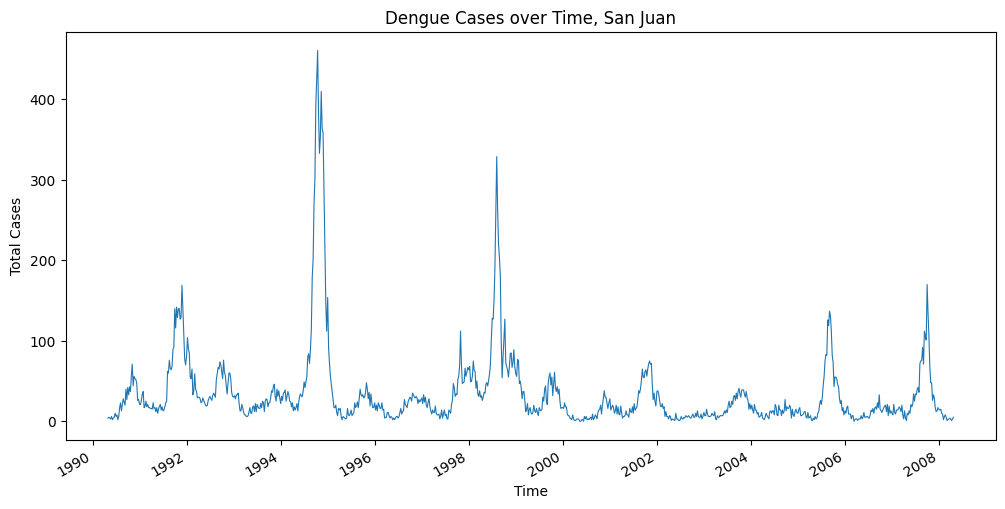

In [37]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(sj_df['total_cases']
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, San Juan')
plt.xlabel('Time')
plt.ylabel('Total Cases')

# Show the plot
plt.show()

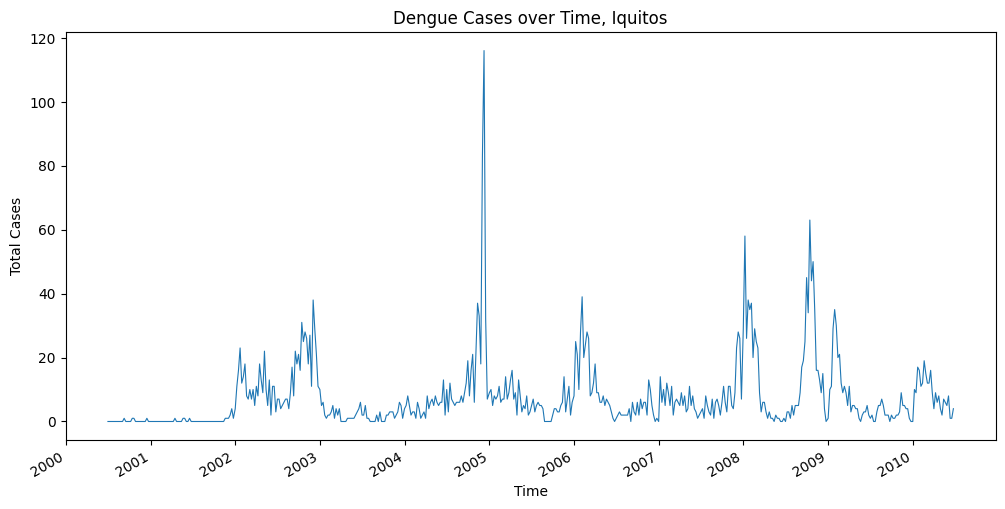

In [38]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(iq_df['total_cases']
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, Iquitos')
plt.xlabel('Time')
plt.ylabel('Total Cases')

# Show the plot
plt.show()

There is a conspicuously quiet period at the start of Iquitos' timeseries plot.  It's worth noting.  

There doesn't seem to be a trend, up or down, in the case count for either city over the span of the dataset.  The data would therefore be *trend stationary*.  Of course the scale is set to capture the highest spikes, so any trending happening in the less extreme regions is missed.  The plots are reproduced below with lower y-axis limits to address this.

There may be some seasonality in the spikes seen, but this is a bit more visible and repeatable in the San Juan data, even if some of the spikes differ in size.  That latter observation is presumably explicable by variables impacting cases in any given year, such as higher than usual precipitation or the like.

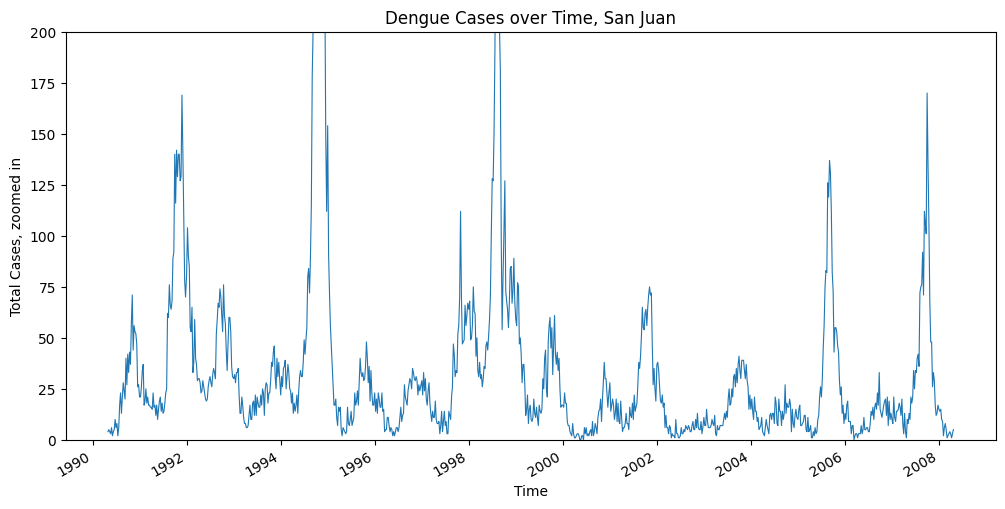

In [39]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(sj_df['total_cases']
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, San Juan')
plt.xlabel('Time')
plt.ylabel('Total Cases, zoomed in')
plt.ylim(0, 200)

# Show the plot
plt.show()

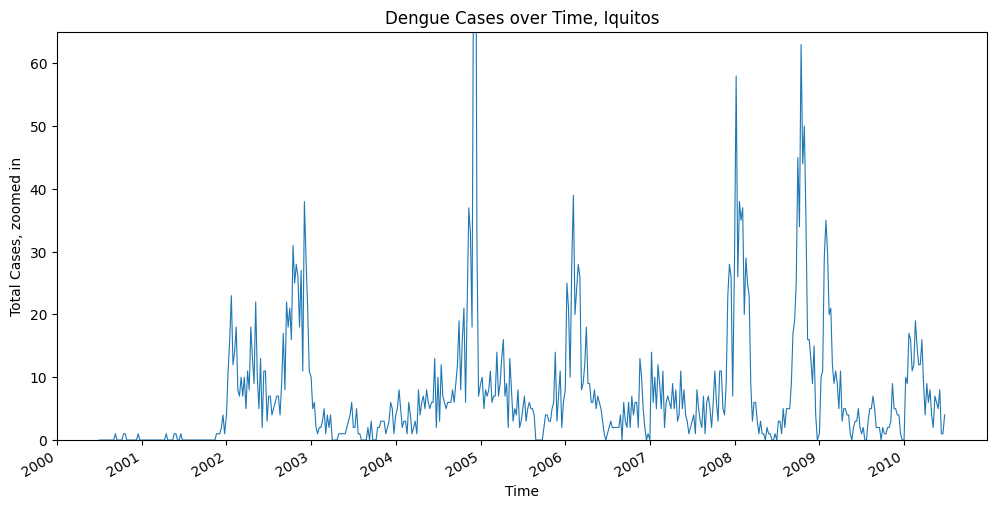

In [40]:
plt.figure(figsize=(12, 6))  # Adjust the figsize according to your preference

# Plot the data
(iq_df['total_cases']
    .plot
    .line(lw=0.8))

# Set title and labels
plt.title('Dengue Cases over Time, Iquitos')
plt.xlabel('Time')
plt.ylabel('Total Cases, zoomed in')
plt.ylim(0, 65)

# Show the plot
plt.show()

# !  
Timeseries *by year*  
a) Consider plotting for each year, for a given city, on one plot (line plots, but one line per year), OR  
b) A polar seasonal plot: cases are displayed in a circular format around a 'clock' of the year, each year its own line, 1 polar plot per city

Could be informative to identify seasonality.  Looking at all years at once makes it harder to spot a seasonal pattern like spikes during certain months of the year, perhaps following a rainy season.

Let's see the histograms of dengue cases for each city.  

When your mind is used to time invariant data... look at these histograms this way:  for a dataframe tracking people with or without diabetes, for example, you may be interested in a histogram of pregnancies.  In this case, the histogram represents how many rows (patients) had 0, 1, 2, 3, etc... pregnancies.  

For this timeseries, the histogram captures how many rows (snapshots in time) have a dengue count of 0, ... to however many the highest count in the dataset is.  The plot for San Juan below shows that at its very worst, the dengue count for the timespan of this dataset got as high as greater than 400 cases.  But by far, the count that appears the most frequently in this record of cases over time is near zero.  

For Iquitos, the highest count occurs near 120, but again, the most frequent count of cases seen in this record over years is near zero.

The value counts done below each histogram support this observation.  

#### Stationarity  

There may be valuable information in these histograms:  a "squashed" distribution as what's seen below may be a flag that the timeseries are non-stationary.  Stationary data have a mean and variance that do not change with time, and the classical statistical models assume the data is stationary.  If data are found to be non-stationary, they can be made stationary using differencing:  subtracting the last value from the current value.  Other times data may be transformed by some other means to make it "more stationary".  

One way to check for stationarity by some other means than a visual check is to split the data into two (or more) parts, calculate the mean and variance, and see if they seem significantly different.  Performing statistical tests to check for the statistical significance of this difference is said to be difficult due to the serial correlation between the data points.  

Another option is to perform the Augmented Dickey-Fuller test, or the unit root test.  This is performed below the histograms.

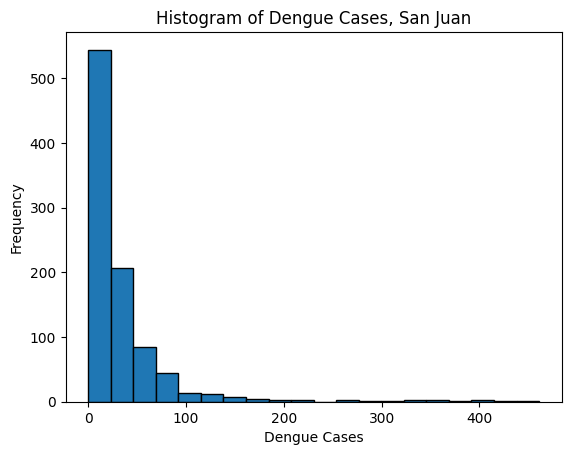

In [41]:
(sj_df['total_cases']
     .plot
     .hist(bins=20, edgecolor='black'))  # Adjust the number of bins as needed

plt.title('Histogram of Dengue Cases, San Juan')
plt.xlabel('Dengue Cases')
plt.ylabel('Frequency')

plt.show()

In [42]:
unique_counts = sj_df['total_cases'].value_counts()
print(unique_counts)

total_cases
6      35
3      34
7      34
17     33
4      28
       ..
359     1
288     1
221     1
90      1
135     1
Name: count, Length: 134, dtype: int64


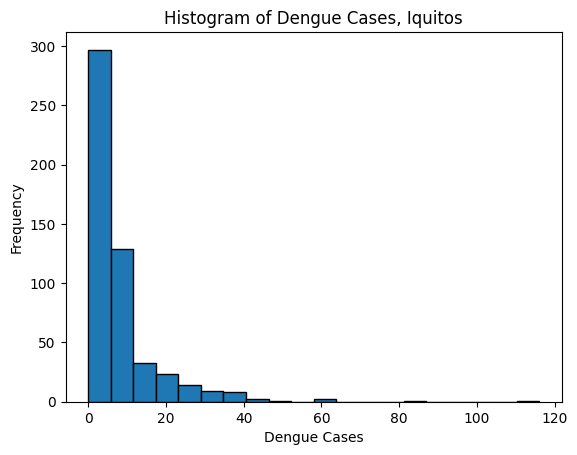

In [43]:
(iq_df['total_cases']
     .plot
     .hist(bins=20, edgecolor='black'))  # Adjust the number of bins as needed

plt.title('Histogram of Dengue Cases, Iquitos')
plt.xlabel('Dengue Cases')
plt.ylabel('Frequency')

plt.show()

In [44]:
unique_counts = iq_df['total_cases'].value_counts()
print(unique_counts)

total_cases
0      96
1      47
2      46
5      44
6      36
3      36
4      28
7      24
9      21
8      20
11     17
10     11
12      9
16      8
13      7
18      6
21      5
26      4
29      4
25      4
28      4
14      4
35      3
22      3
23      3
19      3
17      3
20      3
15      2
38      2
37      2
31      1
50      1
44      1
63      1
34      1
45      1
32      1
58      1
24      1
39      1
116     1
83      1
33      1
27      1
30      1
Name: count, dtype: int64


### Train_Test_Split for Timeseries  

The usual train_test_split function cannot be used on timeseries as the order of rows is of critical importance for modelling a system to obtain predictions.  The split below is done by a 70/30 split on each city's dataset with the first 70% being the training dataset.

The split below is for process' sake:  the splits are done on the exported datasets (done above) in the modelling notebooks specific to each model algorithm used as this is built-in to the functions templated for the very involved data format preparation for modelling timeseries using supervised learning algorithms designed for time-invariant data.  Some models are more computationally costly than others, and may require smaller training or test set sizes, especially when multivariate cases are prepared.

So in a perfect situation, a train-test-split is done once and this is what it used for all models.  In reality, many model algorithms are being trialled, some are fairly cumbersome to use for timeseries, and we don't have infinite access to computing resources.  Compromises are made.  

With that said this split is reproduced in the Statsmodels Autoregression notebook, and can be attempted on other modelling algorithms, compute power willing.

The below proceeds with an investigation of stationarity using the training data only, as we would normally only have "seen" data to work with to set up our inputs to our models.  Unseen data may or may not be stationary, but it is generally safe to assume, for a given system/process, that if the data you have is stationary (or non-stationary), the future observations will exhibit similar behaviour.  Model performance degradation would prompt a re-examination of this assumption.  

In [45]:
total_rows = sj_df.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"San Juan training set size: {train_rows} rows")
print(f"San Juan testing set size: {test_rows} rows")

# Create the training and testing sets
sj_df_train = sj_df.iloc[:train_rows]
sj_df_test = sj_df.iloc[train_rows:]

San Juan training set size: 655 rows
San Juan testing set size: 281 rows


In [46]:
total_rows = iq_df.shape[0]
train_rows = int(total_rows * 0.70)
test_rows = total_rows - train_rows

print(f"Iquitos training set size: {train_rows} rows")
print(f"Iquitos testing set size: {test_rows} rows")

# Create the training and testing sets
iq_df_train = iq_df.iloc[:train_rows]
iq_df_test = iq_df.iloc[train_rows:]

Iquitos training set size: 364 rows
Iquitos testing set size: 156 rows


##### Augmented Dickey-Fuller Test for Stationarity  
The details were discussed above.  The below executes the tests and comments on the results.

Reference:  https://machinelearningmastery.com/time-series-data-stationary-python/  

In [47]:
result_sj = adfuller(sj_df_train['total_cases'])
print('ADF Statistic: %f' % result_sj[0])
print('p-value: %f' % result_sj[1])
print('Critical Values:')
for key, value in result_sj[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.596359
p-value: 0.000001
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [48]:
result_iq = adfuller(iq_df_train['total_cases'])
print('ADF Statistic: %f' % result_iq[0])
print('p-value: %f' % result_iq[1])
print('Critical Values:')
for key, value in result_iq[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.131271
p-value: 0.000012
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


The statistic given by the ADF is said to be interpretable as follows:
* The more negative the statistic, the more likely the data is stationary
* If the statistic is less than the 5% or the 1% value (whichever threshold you select), the data is more likely to be stationary
* If the p-value is less than 0.05, there is support to reject the null hypothesis (H0: the data is non-stationary) and conclude that the data is stationary.

We will continue with the defensible assumption that the data for the target, total_cases, is stationary.

### Autocorrelation: can the target be predicted based on past values of itself?  

`.lag_plot()` lets you see if a given variable has the potential to be predicted based on its past values.  This is only with a lag of 1, and already we see a clear relationship.

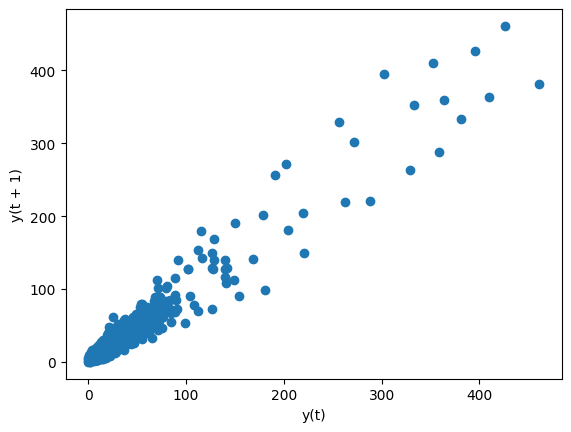

In [49]:
lag_plot(sj_df_train['total_cases'])
plt.show()

The plot below shows the lagged target values on the x-axis and the "present time" target values on the y-axis.  

In other words, for each case count found in the dataset at time t (or the "current row"), this is the y coordinate, its corresponding lagged case count is taken as the other coordinate.  This is done as (x,y) = (case count at lag k, case count at present time), and k takes on values of 1, 2, and 3 to plot below.

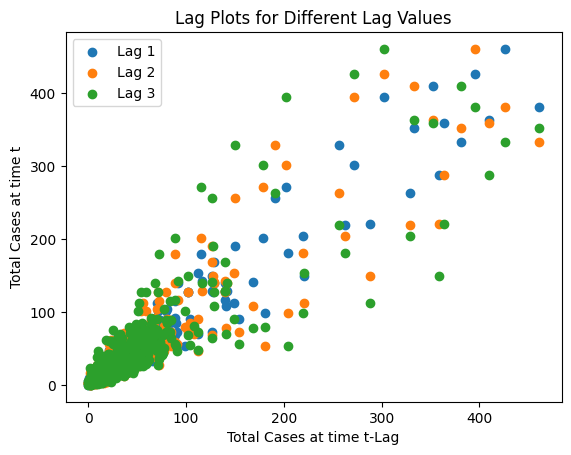

In [50]:
lag_values = [1, 2, 3]  # You can adjust this list to include the lags you are interested in

# Plot the lag plots for each lag
for lag in lag_values:
    plt.scatter(sj_df_train['total_cases'].shift(lag), sj_df_train['total_cases'], label=f'Lag {lag}')

plt.xlabel('Total Cases at time t-Lag')
plt.ylabel('Total Cases at time t')
plt.legend()
plt.title('Lag Plots for Different Lag Values')
plt.show()
    

There's a lot of data for 0 to 100 cases, but less as you get to higher case counts.  Additionally, it could be informative to plot the lag plots *per year*, rather than all years thrown in, or per quarter, and this could be Q1 for all years put together, and then Q2 for all years put together, and so on.  It could reveal some seasonality to the case count, which could be expected for a mosquito-borne illness.

We could plot lag plots enough to paper the walls, but ultimately what allows for some automation (pipelining) is producing the correlation values for the target against its lagged self at various lags, and identifying the lag where the maximum correlation value occurs.  

To the question is how many lags back to do want to check for autocorrelation in the target variable, cases?  This is limited to how much data we have.  We'll see the number of rows available for San Juan and Iquitos.

In [51]:
print(f"San Juan has {sj_df_train.shape[0]} rows of training data, each representing a snapshot in time one week after the last row.")
print(f"Iquitos has {iq_df_train.shape[0]} rows of training data, each representing a snapshot in time one week after the last row.")

San Juan has 655 rows of training data, each representing a snapshot in time one week after the last row.
Iquitos has 364 rows of training data, each representing a snapshot in time one week after the last row.


Each lag, as far as the dataframe is concerned, is simply one row.  In real terms (to us), that's one week.  Given the period of time it takes to hatch mosquitos, and for the infectious bites to occur and for symptoms to appear, one might guess a few weeks, so a few rows.  In one paper, the optimal lag was found to be no more than 12 weeks by meteorological variables, but that will be discussed later as we enter the multivariate part of the analysis.  We may not have to go back that far for an autoregression on targets.  

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7537891/#:~:text=These%20values%20were%20selected%20as,weeks%20%5B49%E2%80%9354%5D.

Let's see if we can get autocorrelations on the target variable, cases, for each city up to 12 lags (rows/weeks) behind.  Even if lag 12 is far too much for an autocorrelation, it's a good template for when the time comes to check the optimal lag against the features, where we expect to see a greater 'optimal lag' value.

We'll start with San Juan.

In [52]:
num_lags = 12

# Create lagged columns and concatenate them to the original DataFrame
lagged_columns = [sj_df_train['total_cases'].shift(i) for i in range(1, num_lags + 1)]
lagged_columns.insert(0, sj_df_train['total_cases'])  # Insert the original column

# Concatenate the lagged columns
sj_df_train_lagged = pd.concat(lagged_columns, axis=1)

# Rename the columns
sj_df_train_lagged.columns = ['t'] + [f't-{i}' for i in range(1, num_lags+1)]
sj_df_train_lagged.head(13)

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
weekstartdate_dt,,,,,,,,,,,,,
1990-04-30,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-07,5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-14,4,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-21,3,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-28,6,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-06-04,2,6.0,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-06-11,4,2.0,6.0,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1990-06-18,5,4.0,2.0,6.0,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN
1990-06-25,10,5.0,4.0,2.0,6.0,3.0,4.0,5.0,4.0,NaN,NaN,NaN,NaN


In [53]:
# use the dataframe to calculate correlations in one shot
correlations_sj = sj_df_train_lagged.corr()

# Print the correlations
print(correlations_sj)

             t       t-1       t-2       t-3       t-4       t-5       t-6  \
t     1.000000  0.966684  0.920855  0.868341  0.816197  0.756343  0.690832   
t-1   0.966684  1.000000  0.966667  0.920835  0.868270  0.816115  0.756208   
t-2   0.920855  0.966667  1.000000  0.966664  0.920793  0.868213  0.816015   
t-3   0.868341  0.920835  0.966664  1.000000  0.966661  0.920766  0.868169   
t-4   0.816197  0.868270  0.920793  0.966661  1.000000  0.966649  0.920724   
t-5   0.756343  0.816115  0.868213  0.920766  0.966649  1.000000  0.966639   
t-6   0.690832  0.756208  0.816015  0.868169  0.920724  0.966639  1.000000   
t-7   0.621609  0.690659  0.756076  0.815948  0.868098  0.920691  0.966620   
t-8   0.551135  0.621424  0.690512  0.755985  0.815861  0.868042  0.920655   
t-9   0.475590  0.550898  0.621229  0.690391  0.755860  0.815779  0.867973   
t-10  0.404711  0.475286  0.550645  0.621071  0.690217  0.755744  0.815673   
t-11  0.336480  0.404364  0.474989  0.550453  0.620857  0.690068

Now let's visualize this in a heatmap.

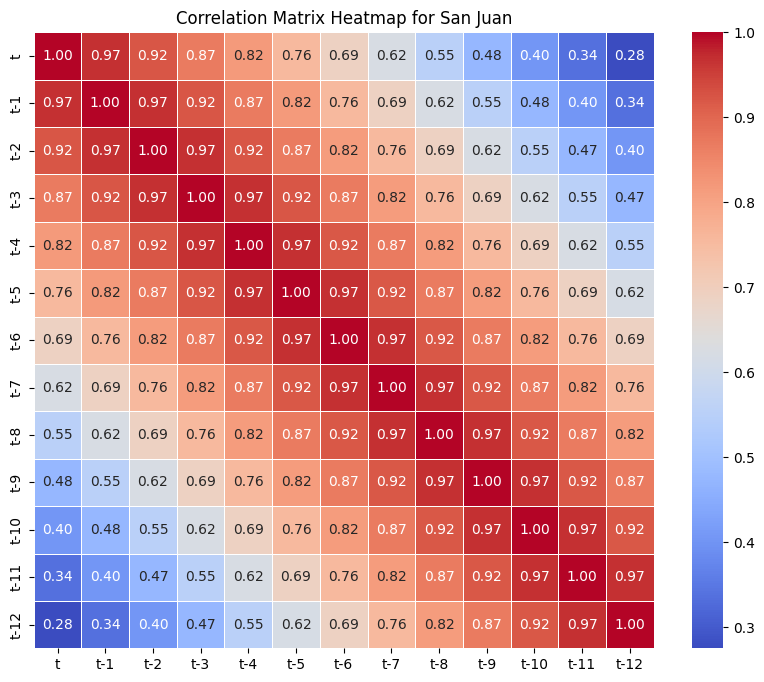

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_sj, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap for San Juan")
plt.show()


We should not be surprised that the case count is most strongly correlated with itself one lag (one week) behind.  As any epidemic will demonstrate, the more infections spread, the faster it "takes off".  This also parallels the general notion that the most recent behaviour in a system is normally a good indicator of its next state, while looking further behind, on its own, may not yield as much insight and proves unpredictable.  This is why we have features to support our predictive efforts in the multivariate part of this project.

So lag = 1 will suffice for autoregression.  

Let's repeat it for Iquitos.

In [55]:
num_lags = 12

# Create lagged columns and concatenate them to the original DataFrame
lagged_columns = [iq_df_train['total_cases'].shift(i) for i in range(1, num_lags + 1)]
lagged_columns.insert(0, iq_df_train['total_cases'])  # Insert the original column

# Concatenate the lagged columns
iq_df_train_lagged = pd.concat(lagged_columns, axis=1)

# Rename the columns
iq_df_train_lagged.columns = ['t'] + [f't-{i}' for i in range(1, num_lags+1)]
iq_df_train_lagged.head(13)

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
weekstartdate_dt,,,,,,,,,,,,,
2000-07-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-08,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-15,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-22,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-29,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-05,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-12,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-19,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2000-08-26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [56]:
# use the dataframe to calculate correlations in one shot
correlations_iq = iq_df_train_lagged.corr()

# Print the correlations
print(correlations_iq)

             t       t-1       t-2       t-3       t-4       t-5       t-6  \
t     1.000000  0.700107  0.489645  0.485796  0.457470  0.339483  0.274413   
t-1   0.700107  1.000000  0.699910  0.489425  0.485657  0.457793  0.339394   
t-2   0.489645  0.699910  1.000000  0.699785  0.489284  0.486094  0.457764   
t-3   0.485796  0.489425  0.699785  1.000000  0.699719  0.489523  0.486041   
t-4   0.457470  0.485657  0.489284  0.699719  1.000000  0.699903  0.489473   
t-5   0.339483  0.457793  0.486094  0.489523  0.699903  1.000000  0.700005   
t-6   0.274413  0.339394  0.457764  0.486041  0.489473  0.700005  1.000000   
t-7   0.294616  0.275127  0.340311  0.458406  0.486533  0.489450  0.700407   
t-8   0.247665  0.294402  0.274874  0.340147  0.458305  0.486685  0.489398   
t-9   0.211466  0.247323  0.294027  0.274613  0.339978  0.458528  0.486627   
t-10  0.187774  0.211717  0.247659  0.294232  0.274751  0.339945  0.458621   
t-11  0.167338  0.187632  0.211571  0.247553  0.294154  0.274823

Now let's visualize this in a heatmap.

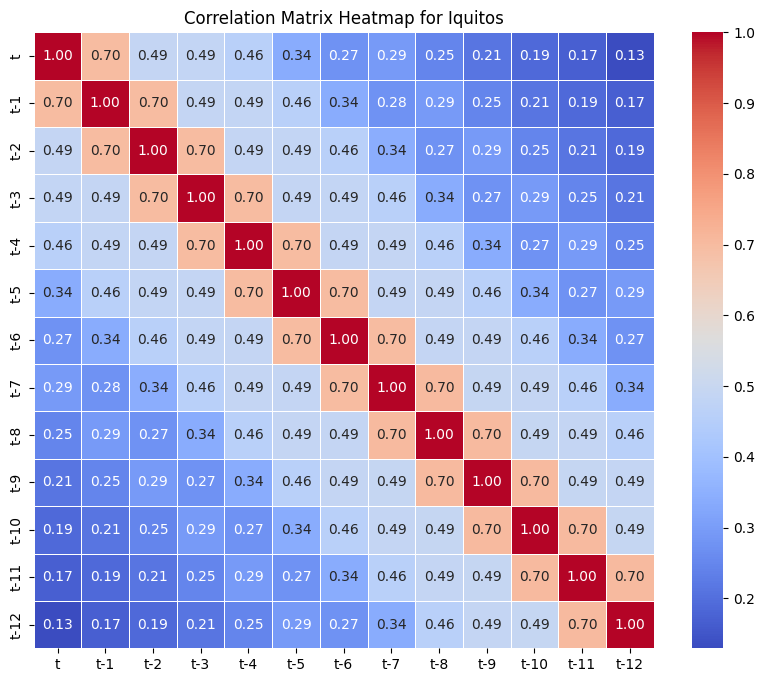

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_iq, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap for Iquitos")
plt.show()


Interesting difference, and not subtle.  The autocorrelations for case counts in San Juan are noticeably stronger than they are for Iquitos.  The one lag autocorrelation at 0.70 for Iquitos is still significant, but much weaker than the 0.97 seen for San Juan.  

And because plots are so handy to estimate ideal model inputs, let's produce a couple autocorrelation plots to confirm that lag 1 really is the best for both San Juan and Iquitos' case count.  Both pandas and statsmodels provide this utility.  

Per the below-referenced website, the pandas autocorrelation plot provides confidence intervals:  "The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values."

Reference: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/  

We'll start with San Juan using pandas, then statsmodels.

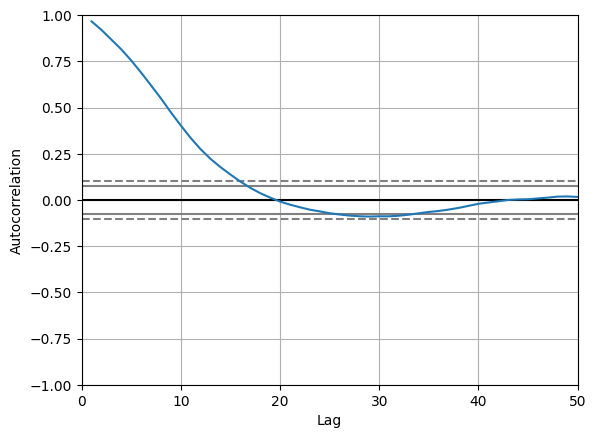

In [58]:
# goes past 800 lags... there's 936 rows of data for San Juan, so that's no surprise.  I've set this limit knowing we're not likely to analyze past 12.  
# It is interesting to change it though.
max_lag=50
autocorrelation_plot(sj_df_train['total_cases'])
plt.xlim(0, max_lag) 
plt.show()

And now for Statsmodels' take on the autocorrelation plot.  It's comforting to see they produce the same result.

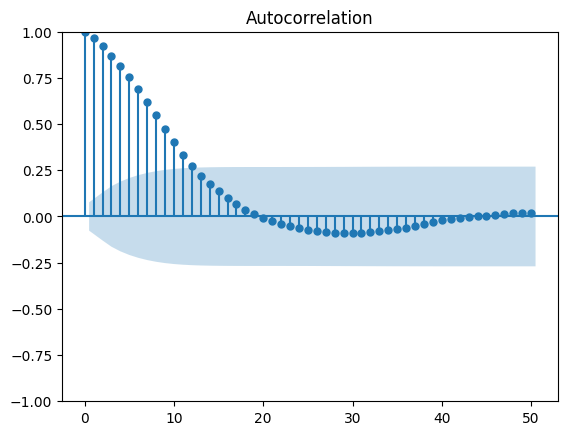

In [59]:
plot_acf(sj_df_train['total_cases'], lags=50)
plt.show()

And now for Iquitos.

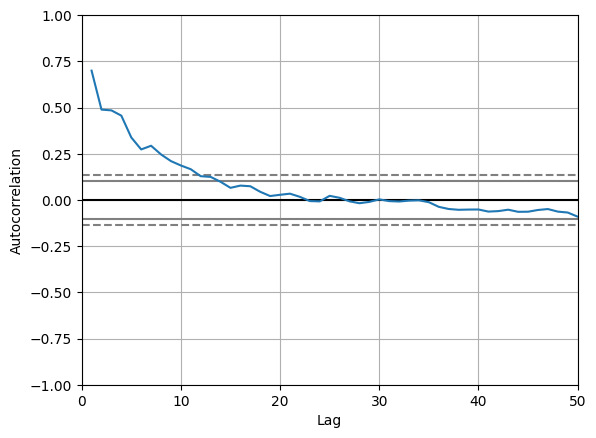

In [60]:
# goes past 500 lags for Iquitos, which is in-line with its row count at 520.
max_lag=50
autocorrelation_plot(iq_df_train['total_cases'])
plt.xlim(0, max_lag) 
plt.show()

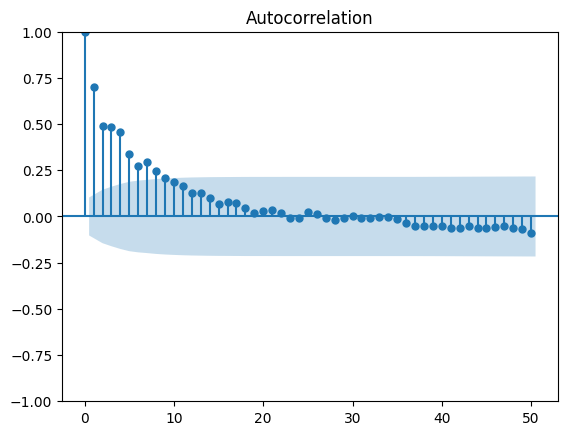

In [61]:
plot_acf(iq_df_train['total_cases'], lags=50)
plt.show()

A lag of one seems to be quite adequate for San Juan, similarly for Iquitos.  Interestingly, the autocorrelation plots for San Juan are much smoother looking than Iquitos.  

The next step is to take the exported CSVs of San Juan and Iquitos data and use it in several different modelling algorithms.  These are found in separate notebooks.